Import what we need

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import scipy
import glob
import datetime
%matplotlib inline

Define some useful functions

In [2]:
# useful func
def zscore(x):
    return (x - (x.astype(float)).mean())/(x.astype(float)).std()

# in order to calculate distance between points using coordinates
from math import radians, cos, sin, asin, sqrt

def haversine(coords1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    
    lon1, lat1 = coords1
#     lon2, lat2 = coords2
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth 6371 for kilometers. 3956 for miles
    return c * r

# define function to calculate distance from JFK
def distFromJFK(coords):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # JFK coordinates
    latJFK = 40.6397
    lonJFK = -73.7789
    
#     return np.sqrt((lonJFK - coords[0])**2 + (latJFK - coords[1])**2)
    return haversine((lonJFK, latJFK), coords[0], coords[1])

Load the data from pickels

In [3]:
fList = glob.glob('/Users/eladg/Documents/Git/NYC_Data_IPA/Taxi/allTaxiData*.pkl')
fListDist = glob.glob('/Users/eladg/Documents/Git/NYC_Data_IPA/Taxi/dJFK*.pkl')
dfList = []
distList = []
testList = ['trip_time_in_secs', 'trip_distance', 'dropoff_latitude', 'dropoff_longitude'] # list of columns to test
for idx,file in enumerate(fList):
    currDF = pd.read_pickle(file)
    currDist = pd.read_pickle(fListDist[idx])
#     currDist = currDF[['dropoff_longitude', 'dropoff_latitude']].apply(distFromJFK,axis=1)
    
    # clean the data during the loading procedure to keep memory cost low
    goodEntries = (currDF[testList] != 0).all(axis=1) &\
    (currDF[testList] < np.inf).all(axis=1)
    currDF = currDF[goodEntries]
    currDist = currDist[goodEntries]
    goodEntries2 = (currDF[testList].apply(zscore) < 10).all(axis=1)
    currDF = currDF[goodEntries2]
    currDist = currDist[goodEntries2]
    dfList.append(currDF)
    distList.append(currDist)
#     if idx>0:
#         break
    
df = pd.concat(dfList)
dJFK = pd.concat(distList)

Histogram the distance of dropoffs from JFK (only look at dropoffs close to JFK)

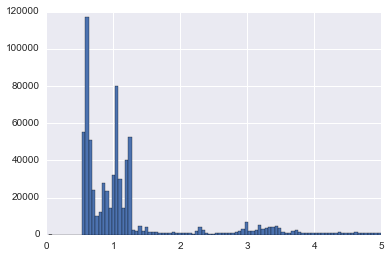

In [4]:
dJFK[dJFK<5].hist(bins=100)

Define trips to JFK as trips ending less than 2 miles from the JFK coordinate

In [5]:
tripsToAirport = dJFK < 2
dfAirport = df[tripsToAirport]

Calculate dropoff time from pickup time and trip duration

In [11]:
dateDur = dfAirport[['pickup_date', 'trip_time_in_secs']]
dropoffTime = dateDur.apply(lambda x: np.floor((x['pickup_date'] +
                                                  datetime.timedelta(0,x['trip_time_in_secs'])).hour % 24), axis=1)

## Pick day hour and location for travel to airport

In [8]:
day = np.arange(0,5)
hour = 19
location = (-74,40.74)
distFromLoc = dfAirport[['pickup_longitude', 'pickup_latitude']].apply(haversine, args=location, axis=1)
tripTimes = dfAirport['trip_time_in_secs'][(dfAirport['pickup_day_of_week'].isin(day)) &\
                                           (dropoffTime == hour) &\
                                          (distFromLoc < 0.3)]

Try to present travel time distribution as violin plot

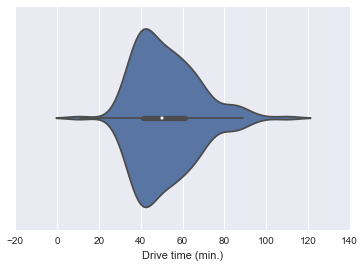

In [9]:
sns.violinplot(tripTimes/60)
plt.xlabel('Drive time (min.)')

Or box plot

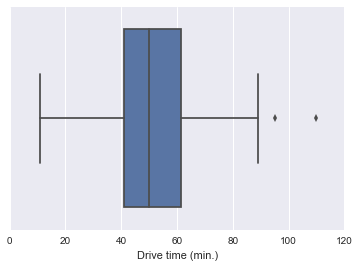

In [10]:
sns.boxplot(tripTimes/60)
plt.xlabel('Drive time (min.)')